# Вводные:

При решении данной задачи опирался на формулы и код на ресурсе: https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/naive-bayes.html

In [1]:
import torch
import torchvision
import time
import matplotlib.pyplot as plt

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda x: torch.floor(x * 255 / 128).squeeze(dim=0)
])

In [3]:
mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform, download=True)
mnist_test  = torchvision.datasets.MNIST('.', train=False, transform=transform, download=True)

(-0.5, 27.5, 27.5, -0.5)

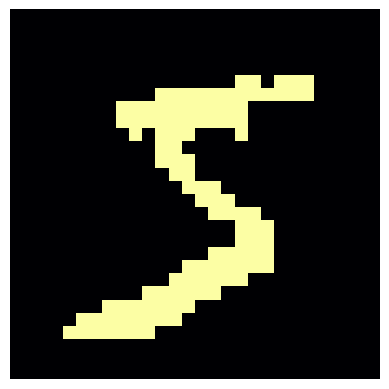

In [4]:
sample = mnist_train[0][0]
plt.imshow(sample, cmap='inferno', vmin=0, vmax=1)
plt.axis('off')

In [5]:
x_5 = mnist_train.data[mnist_train.targets==5]

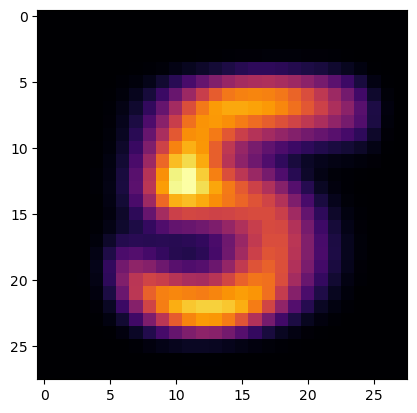

In [6]:
plt.imshow(x_5.sum(axis=0)/x_5.sum(axis=0).max(),cmap='inferno')

# Решение:

Формула Naive Bayes для классификации:

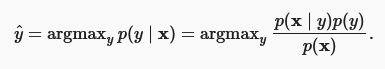

Опуская все выкладки, нам необходимо расчитать значения P_y и P_xy и привести к логарифмам:

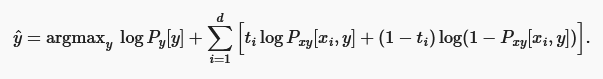

Выкладки и рассуждения о том, как мы пришли к конечной формуле: https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/naive-bayes.html

P_y по сути нормализация количества каждого класса в датасете (около 10% на каждый класс): 

In [7]:
X = torch.stack([mnist_train[i][0] for i in range(len(mnist_train))], dim=0)
Y = torch.tensor([mnist_train[i][1] for i in range(len(mnist_train))])

#    считаем количества каждой из цифр, делим на общее число цифр
n_y = torch.zeros(10)
for y in range(10):
    n_y[y] = (Y == y).sum()
P_y = n_y / n_y.sum()
P_y

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

P_xy - то, как в среднем выглядит каждый класс. Своего рода тепловая карта по признакам (пикселям). Чем чаще встречается пиксель в картинках датасета той или иной цифры - тем он ярче на 'тепловой карте'.

In [8]:
n_x = torch.zeros((10, 28, 28))
for y in range(10):
    n_x[y] = torch.tensor(X.numpy()[Y.numpy() == y].sum(axis=0))
P_xy = (n_x + 1) / (n_y + 2).reshape(10, 1, 1)

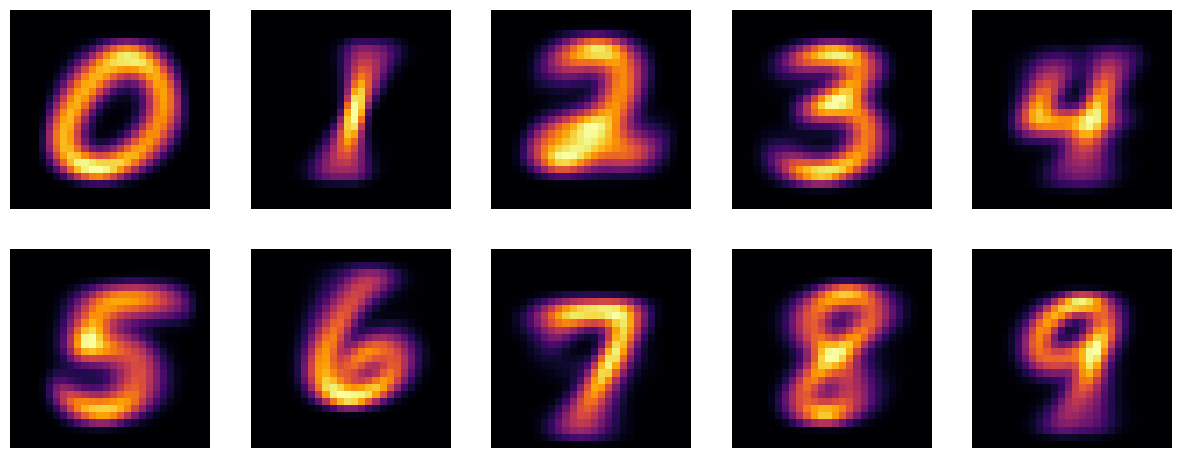

In [9]:
#    как выглядят 'тепловые карты' цифр
fig = plt.figure(figsize = (15,15))
for i in range(0,10):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(P_xy[i], cmap='inferno')

In [10]:
#    конечная формула
log_P_xy = torch.log(P_xy)
log_P_xy_neg = torch.log(1 - P_xy)
log_P_y = torch.log(P_y)

def bayes_pred_stable(x):
    x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
    p_xy = p_xy.reshape(10, -1).sum(axis=1)  # p(x|y)
    return p_xy + log_P_y

(-0.5, 27.5, 27.5, -0.5)

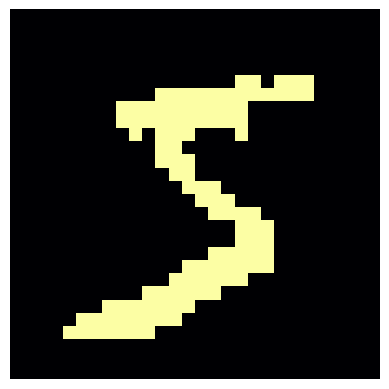

In [11]:
#    картинка, которую рассматривали как пример выше
plt.imshow(sample, cmap='inferno', vmin=0, vmax=1)
plt.axis('off')

In [15]:
#    попробуем предсказать, что это за цифра
sample_pred = bayes_pred_stable(mnist_train[0][0])
sample_pred

tensor([-266.6501, -320.7928, -261.5018, -202.6297, -295.5724, -199.4972,
        -318.6622, -266.0147, -224.5957, -271.9329])

In [13]:
#    максимальный score в тензоре показывает к какому классу ближе всего предсказанное значение
#    выведем индекс максимального - это и будет наша предсказанная цифра
sample_pred.argmax()

tensor(5)

In [16]:
#    стоит заметить, что значение по индексу '3' несильно отличается от предсказания
#    визуально картинка с '5' действительно похожа и на '3'

In [14]:
#    рассчитаем accuracy предсказаний
def predict(X):
    return [bayes_pred_stable(x).argmax(dim=0).type(torch.int32).item() for x in X]

X = torch.stack([mnist_test[i][0] for i in range(len(mnist_test))], dim=0)
y = torch.tensor([mnist_test[i][1] for i in range(len(mnist_test))])
preds = torch.tensor(predict(X), dtype=torch.int32)
print('Accuracy: ', float((preds == y).sum()) / len(y))

Accuracy:  0.8427
